In [10]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import slsim
from slsim.lens_pop import LensPop
import speclite
from astropy.cosmology import default_cosmology
from astropy.units import Quantity
from tqdm import tqdm
from hydra import initialize, compose
from pprint import pprint
from glob import glob
import pandas as pd

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
# plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import util
from mejiro.helpers import survey_sim

In [11]:
import mejiro
module_path = os.path.dirname(mejiro.__file__)
skypy_config = os.path.join(module_path, 'data', 'hri.yml')
config_dict = util.load_skypy_config(skypy_config)
survey_area = float(config_dict['fsky'][:-5])

print(f"Survey area: {survey_area} deg^2")

cosmo = default_cosmology.get()
sky_area = Quantity(value=survey_area, unit='deg2')

Survey area: 0.1 deg^2


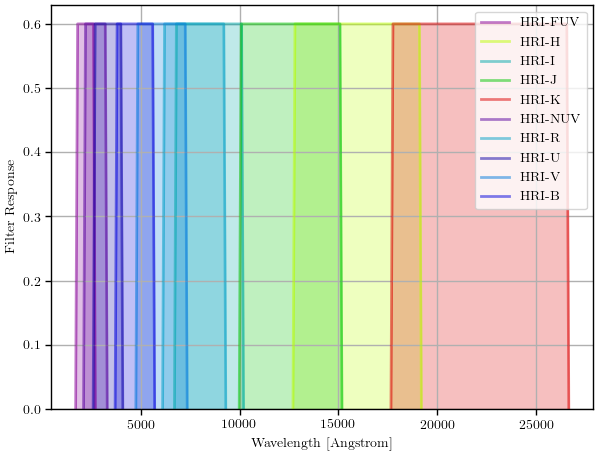

In [12]:
hwo_filters = glob(os.path.join(repo_dir, 'mejiro', 'data', 'hwo_filter_responses', '*.ecsv'))
hri = speclite.filters.load_filters(*hwo_filters)

speclite.filters.plot_filters(hri)

In [13]:
kwargs_deflector_cut = {"z_min": 0.01, "z_max": 8.0}  # "band": "r", "band_max": 28, 
kwargs_source_cut = {"z_min": 0.01, "z_max": 8.0}  # "band": "r", "band_max": 30, 
# kwargs_deflector_cut = {}
# kwargs_source_cut = {}

lens_pop = LensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=skypy_config,
    sky_area=sky_area,
    cosmo=cosmo,
)

In [14]:
kwargs_lens_cut = {
    "min_image_separation": 0.2,
    "max_image_separation": 10,
    # "mag_arc_limit": {"r": 25},
}

lens_population = lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cut)

print("Number of lenses:", len(lens_population))

Number of lenses: 31139


In [15]:
bands = ['FUV', 'NUV', 'U', 'B', 'V', 'R', 'I', 'J', 'H', 'K']
column_headers = ['z_source', 'z_lens', 'stellar_mass', 'einstein_radius', 'velocity_dispersion']

for band in bands:
    column_headers.append(f'source_mag_{band.lower()}')
    column_headers.append(f'lensed_source_mag_{band.lower()}')
    column_headers.append(f'lens_mag_{band.lower()}')

print(column_headers)

['z_source', 'z_lens', 'stellar_mass', 'einstein_radius', 'velocity_dispersion', 'source_mag_fuv', 'lensed_source_mag_fuv', 'lens_mag_fuv', 'source_mag_nuv', 'lensed_source_mag_nuv', 'lens_mag_nuv', 'source_mag_u', 'lensed_source_mag_u', 'lens_mag_u', 'source_mag_b', 'lensed_source_mag_b', 'lens_mag_b', 'source_mag_v', 'lensed_source_mag_v', 'lens_mag_v', 'source_mag_r', 'lensed_source_mag_r', 'lens_mag_r', 'source_mag_i', 'lensed_source_mag_i', 'lens_mag_i', 'source_mag_j', 'lensed_source_mag_j', 'lens_mag_j', 'source_mag_h', 'lensed_source_mag_h', 'lens_mag_h', 'source_mag_k', 'lensed_source_mag_k', 'lens_mag_k']


In [16]:
lens_pop_params = []
for lens in lens_population:
    lens_params = []
    lens_params.append(lens.source_redshift)
    lens_params.append(lens.deflector_redshift)
    lens_params.append(lens.deflector_stellar_mass())
    lens_params.append(lens.einstein_radius)
    lens_params.append(lens.deflector_velocity_dispersion())

    for band in bands:
        lens_params.append(lens.extended_source_magnitude(band.lower(), lensed=False))
        lens_params.append(lens.extended_source_magnitude(band.lower(), lensed=True))
        lens_params.append(lens.deflector_magnitude(band.lower()))
    
    lens_pop_params.append(lens_params)

df = pd.DataFrame(lens_pop_params, columns=column_headers)
df.to_csv(os.path.join(repo_dir, 'hwo_lens_population.csv'), index=True)

In [17]:
band = 'j'

source_redshifts = df.loc[:,'z_source']
lens_redshifts = df.loc[:,'z_lens']
stellar_masses = df.loc[:,'stellar_mass']
einstein_radii = df.loc[:,'einstein_radius']
velocity_dispersions = df.loc[:,'velocity_dispersion']
source_mags = df.loc[:,f'source_mag_{band}']
lensed_source_mags = df.loc[:,f'lensed_source_mag_{band}']
lens_mags = df.loc[:,f'lens_mag_{band}']

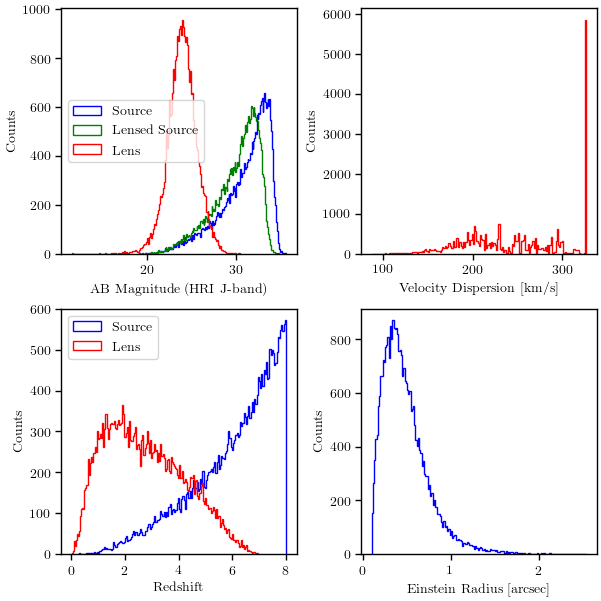

In [19]:
bins = int(np.sqrt(len(lens_population)))

_, ax = plt.subplots(2, 2, figsize=(6, 6), constrained_layout=True)

ax[0][0].hist(source_mags, bins=bins, histtype='step', color='b', label='Source')
ax[0][0].hist(lensed_source_mags, bins=bins, histtype='step', color='g', label='Lensed Source')
ax[0][0].hist(lens_mags, bins=bins, histtype='step', color='r', label='Lens')
ax[0][0].set_xlabel('AB Magnitude (HRI J-band)')
ax[0][0].set_ylabel('Counts')
ax[0][0].legend()

ax[0][1].hist(velocity_dispersions, bins=bins, histtype='step', color='r', label='Velocity Dispersion')
ax[0][1].set_xlabel('Velocity Dispersion [km/s]')
ax[0][1].set_ylabel('Counts')

ax[1][0].hist(source_redshifts, bins=bins, histtype='step', color='b', label='Source')
ax[1][0].hist(lens_redshifts, bins=bins, histtype='step', color='r', label='Lens')
ax[1][0].set_xlabel('Redshift')
ax[1][0].set_ylabel('Counts')
ax[1][0].legend()

ax[1][1].hist(einstein_radii, bins=bins, histtype='step', color='b', label='Einstein Radius')
ax[1][1].set_xlabel('Einstein Radius [arcsec]')
ax[1][1].set_ylabel('Counts')

plt.savefig(os.path.join(figure_dir, 'hwo_total_population.png'))
plt.show()